In [56]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns
import numpy as np
import random
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from scipy import stats
#import graphviz
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [57]:
#df = sns.load_dataset('iris') # load a pandas dataframe from demo file
df = pds.read_csv('./weather.csv', sep=",") # load a pandas dataframe from csv
df.head()


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [58]:
df.duplicated().sum()

0

In [60]:
df.corr(numeric_only=True)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
Temperature,1.000000,-0.014119,-0.004957,0.006632,-0.007489
Humidity,-0.014119,1.000000,0.003816,0.007244,-0.032089
Wind_Speed,-0.004957,0.003816,1.000000,-0.000405,0.018772
Cloud_Cover,0.006632,0.007244,-0.000405,1.000000,0.023100
Pressure,-0.007489,-0.032089,0.018772,0.023100,1.000000


In [61]:
df.isnull().sum()

Temperature    0
Humidity       0
Wind_Speed     0
Cloud_Cover    0
Pressure       0
Rain           0
dtype: int64

### Preprocessing: Équilibrage des classes 'rain' et 'no rain'

In [4]:
# Compter le nombre de lignes où 'Rain' est égal à 'no rain'
no_rain_count = len(df[df['Rain'] == 'no rain'])
rain_count = len(df[df['Rain'] == 'rain'])
# Affichage du nombre de lignes 'no rain'
print(no_rain_count, rain_count)

2186 314


#### Undersampling : 

In [62]:
# Supposons que votre DataFrame s'appelle df

# Sélectionner aléatoirement 1700 lignes où 'Rain' est égal à 'no rain'
df_no_rain = df[df['Rain'] == 'no rain'].sample(n=1800, random_state=42)

# Supprimer ces 1700 lignes de 'no rain' du DataFrame original
df_balanced = df.drop(df_no_rain.index)

# Vérification du nouveau nombre de lignes
no_rain_count_balanced = len(df_balanced[df_balanced['Rain'] == 'no rain'])
rain_count_balanced = len(df_balanced[df_balanced['Rain'] == 'rain'])

print(no_rain_count_balanced, rain_count_balanced)

df=df_balanced

386 314


In [63]:
classes = df.loc[:,"Rain"]
# Réduire la taille de 'classes' pour qu'elle corresponde à 'dff'
classes = classes.sample(n=df.shape[0], random_state=10)

### Preprocessing:Encodage de la  variable catégorique 'Rain'

In [64]:
classes=df['Rain'].map({'rain':1, 'no rain':0})
df=df.drop(['Rain'], axis=1)

In [65]:
print(df.shape)  # Affiche les dimensions de dff
print(classes.shape)  # Affiche les dimensions de classes

(700, 5)
(700,)


In [66]:
print(classes.unique())

[1 0]


___

In [67]:
#X_train, X_test, y_train, y_test = train_test_split(dff, classes, train_size=0.66)
X_train, X_test, y_train, y_test = train_test_split(df, classes, test_size=0.33, random_state=10)

In [68]:
type(X_train)
# Vérifier les types des colonnes
print(X_train.dtypes)

Temperature    float64
Humidity       float64
Wind_Speed     float64
Cloud_Cover    float64
Pressure       float64
dtype: object


In [84]:
model = ensemble.RandomForestClassifier(n_estimators= 37 , max_depth= 5, criterion = 'entropy', random_state=10,
                                        min_samples_leaf=7,bootstrap=True)

In [85]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 200),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=10),
                                   param_distributions=param_dist,
                                   n_iter=20,  # Nombre d'essais aléatoires
                                   cv=5,
                                   scoring='accuracy',
                                   n_jobs=-1)
random_search.fit(X_train, y_train)
print("Meilleurs paramètres :", random_search.best_params_)

Meilleurs paramètres : {'criterion': 'entropy', 'min_samples_leaf': 9, 'n_estimators': 179}


In [86]:
model.fit(X_train, y_train)
sortedLabelList = sorted(list(set(classes)))
print(sortedLabelList)
y_predict_train = model.predict(X_train)
metrics.confusion_matrix(y_true=y_train, y_pred=y_predict_train, labels=sortedLabelList)


[0, 1]


array([[256,   0],
       [  0, 213]])

In [78]:
y_predict = model.predict(X_test)
print(y_predict[0:5])
print(metrics.accuracy_score(y_test, y_predict))

[0 0 0 0 0]
1.0


In [79]:
sortedLabelList = sorted(list(set(classes)))
metrics.confusion_matrix(y_true=y_test, y_pred=y_predict, labels=sortedLabelList)

array([[130,   0],
       [  0, 101]])

In [80]:
sortedLabelList

[0, 1]

In [81]:
pds.DataFrame(
    metrics.confusion_matrix(y_true=y_test, y_pred=y_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 0,Predicted 1
True 0,130,0
True 1,0,101


In [82]:
print(metrics.classification_report(y_test, y_predict))  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       101

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



In [83]:
pds.DataFrame(model.predict_proba(X_test),
    columns=['Predicted ' + str(className) for className in sortedLabelList]).head(10)

,Predicted 0,Predicted 1
0,0.981618,0.018382
1,0.977124,0.022876
2,0.915686,0.084314
3,1.000000,0.000000
4,0.959681,0.040319
5,1.000000,0.000000
6,0.931373,0.068627
7,0.021557,0.978443
8,0.904958,0.095042
9,0.114321,0.885679


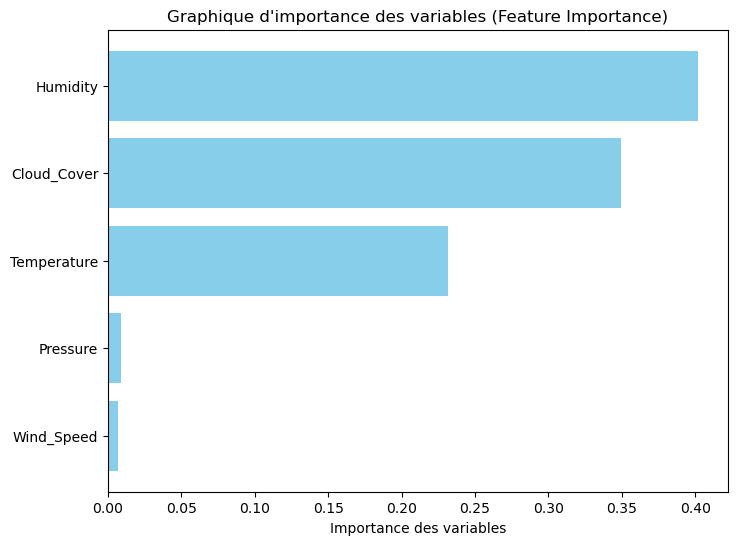

In [23]:
##Importance des variables (Feature Importance)

import matplotlib.pyplot as plt
# Importance des variables
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Graphique
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx)), df.columns[sorted_idx])
plt.xlabel("Importance des variables")
plt.title("Graphique d'importance des variables (Feature Importance)")
plt.show()

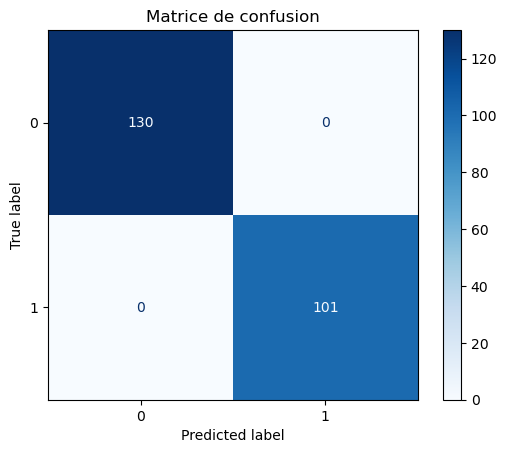

In [24]:
##confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=sortedLabelList, cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

In [34]:
print(X_test.shape)
print(X_test.columns)

(231, 5)
Index(['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure'], dtype='object')


In [87]:
print(metrics.classification_report(y_test, y_predict))  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       101

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



In [88]:
from tabulate import tabulate
from sklearn.metrics import classification_report

# Générer le rapport
report_dict = classification_report(y_test, y_predict, output_dict=True)

# Convertir en tableau tabulé
table = tabulate(pd.DataFrame(report_dict).transpose(), headers="keys", tablefmt="pretty")

# Afficher
print("\n*** Rapport de Classification ***\n")
print(table)


*** Rapport de Classification ***

+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |    1.0    |  1.0   |   1.0    |  130.0  |
|      1       |    1.0    |  1.0   |   1.0    |  101.0  |
|   accuracy   |    1.0    |  1.0   |   1.0    |   1.0   |
|  macro avg   |    1.0    |  1.0   |   1.0    |  231.0  |
| weighted avg |    1.0    |  1.0   |   1.0    |  231.0  |
+--------------+-----------+--------+----------+---------+


In [91]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [93]:
scoring = ['accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted']
#cv = KFold(n_splits=5, random_state=10, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_validate(model, df, classes, scoring=scoring,
                        cv=cv, return_train_score=False)
#scores = cross_validate(model, dff, classes, scoring=scoring,
#                        cv=5, return_train_score=False)
#cv = 5 folds made by StratifiedKFold (default) for sklearn classifiers (all classifiers of class ClassifierMixin)
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted', 'test_f1_macro', 'test_f1_weighted'])

In [95]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle
model = RandomForestClassifier(random_state=10)

# Évaluation avec cross_validate
scores = cross_validate(model, X_train, y_train, scoring='accuracy', cv=5, return_train_score=False)

# Récupération des temps d'ajustement (fit_time)
print("Temps d'ajustement (fit time) pour chaque fold :", scores['fit_time'])
print("Temps moyen d'ajustement :", scores['fit_time'].mean())

Temps d'ajustement (fit time) pour chaque fold : [0.09183288 0.07437205 0.07706285 0.07413507 0.07498693]
Temps moyen d'ajustement : 0.07847795486450196
